# **TP5 : Classification multi-class des images par le MLP**

- L'Encodage d'une image
- La classification multi-class
- Utiliser le MLP du TP4 pour faire un classificateur des images

![reseau1](./reseau1.png)

Rappelons que :
- $\sigma_1(x) = ReLU(x)$
-  $\sigma_2(x) = [\sigma_{softmax}(x_i)] = \left[\frac{e^{x_i}}{\sum_{j=1}^k e^{x_j}}\right]$
  

# Setup l'environement avec Pytorch

- On doit installer le framwork Pytorch
- Il créer un environnement virtuel avec venv et installer Pytorch. 
- **Il faut pas creer dans votre HOME, PyTorch est tres lourde**
- Ensuite selectionner cette l'environnement virtuel pour le Kernel du notebook

In [1]:
# python3 -m venv nom_de_ton_environnement
# source nom_de_ton_environnement/bin/activate
# pip install torch torchvision scikit-learn pandas numpy requests
# pip install Pillow matplotlib
# pip install jupyter   
# python -m ipykernel install --user --name=venv --display-name "PyTorch"

### Chargement et visualisation des images

Telechargez le fichier MNIST_medium depuis CELENE. Decompressez et vous avez la structure suivante :
```console
MNIST/
├── images/
├── train.txt
├── val.txt
├── test_without_labels.txt
```


Shape de l'image:  (28, 28)


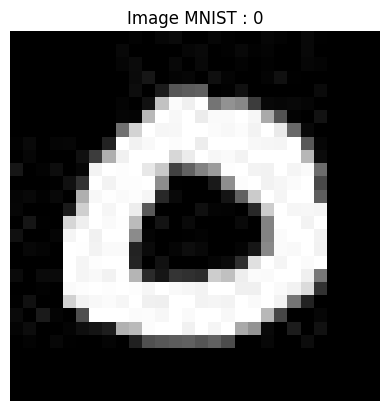

Matrice de pixels :
[[  0   0   0   0   0   0   0   0   0   3   0   6  10   0   0   6   2   0
    0   6   3   0   8   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   8   0   0   0   0   6   9   0   2   8
    2   4   0   0   8   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   5  11   0   0   8   0   8   0   0   3
    0   2   0   0   6   4   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  10  22   0   4   6   0  15   4   0
    0   4  16   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  13   0  27  86  92  96   0   2  16
    0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0  17 194 251 240 255 116 146 136
   61   8   6   8   5   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   5   4 184 255 248 255 236 250 250 255
  247 170  83   3   0  18   0   0   0   0]
 [  0   0   0   0   0   0   0   0 112 212 255 246 247 255 255 251 248 252
  243 255 234 106   8   0   0   0   0   0]
 [  2   9   0   5   6   0   0  34 255 242 24

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Choisir une image aléatoire parmi les fichiers d'images
image_filename = "data/MNIST/images/img_110.jpg"

# Chargement de l'image
image = Image.open(image_filename)

# Conversion de l'image en tableau numpy
image_array = np.array(image)
print("Shape de l'image: ", image_array.shape)

def show_image(image_array, image_class=0):
    # Affichage de l'image
    plt.imshow(image_array, cmap="gray")
    plt.title(f"Image MNIST : {image_class}")
    plt.axis("off")
    plt.show()

    # Affichage du tableau des pixels
    print("Matrice de pixels :")
    print(image_array)

show_image(image_array, image_class=0)


### Load all data from train, val and test; and use Pytorch DataLoader to store images + labels

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from PIL import Image
import numpy as np
import utils
# import importlib 
# importlib.reload(utils)

def load_mnist_data(base_folder_path, split="train"):
    X, y = utils.load_data(base_folder_path, split)
    # Convertir en torch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor


### Vérifiez la fonction load_data

Train data shape: X_val (10500, 28, 28), y_val (10500,)


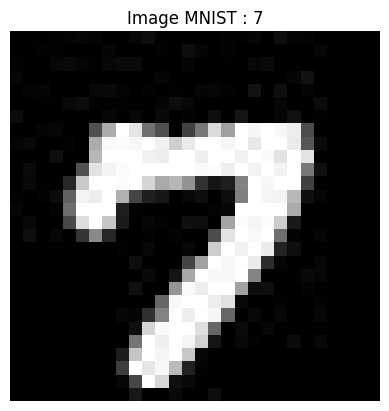

Matrice de pixels :
[[  0   0   1   2   4   6   4   0   0   6  12   1   0   0   0   0   3   2
    5   0  13   4   3   0   0   0   0   0]
 [  0   1   3   2   0   0   0   5   0   0   0   2   0  13   5   0   3   0
    0   0   0   0   0   6   0   0   0   0]
 [  3   0   0   6  10   5   2   6  10  10   0   0   0   5   0   0   1   0
    6  10   0   0   0   0   0   0   0   0]
 [  6   1   0   0   0   0   0   0   0   0   1   5   0   1   0   1   0   0
    0   0   0   5  17   0   0   0   0   0]
 [  0   5   5   0   0   0   8   9   4   0   3   0   2   0   5   6   3   0
   18   0  14   0   4   0   0   0   0   0]
 [  0   0   1   1   7  12   2   0   2   0   0   4  12   6   0   0   0   0
    0   0   6   0   0  11   0   0   0   0]
 [ 11   0   0   0   0   0   0   6   1   7   0   9   0   3   0  14   0  20
    0   0   5  16   0   2   0   0   0   0]
 [  0   0   4   6   0   0  80 172 255 229 114  79   0  65 120 219 160 255
  246 255 248 237  76   0   0   0   0   0]
 [  4   7   0   0   2   0 172 249 251 247 25

In [4]:

# # Exemple d'utilisation de la fonction
base_folder_path = "./data/MNIST/"

# Charger les données d'entraînement
X_val, y_val = utils.load_data(base_folder_path, "val")
print(f"Train data shape: X_val {X_val.shape}, y_val {y_val.shape}")

# Vérifier un élément alératoire dans X_val et y_val
index = random.randint(1, len(X_val))
show_image(X_val[index], y_val[index])


In [5]:
X_train, y_train = load_mnist_data(base_folder_path, "train")
X_val, y_val = load_mnist_data(base_folder_path, "val")
X_test, y_test = load_mnist_data(base_folder_path, "test")
print(X_test.shape, y_test.shape)

# Redimensionner les images pour les adapter au réseau (28x28 pixels)
X_train = X_train.view(X_train.size(0), -1)  # Applatir les images (28x28 -> 784)
X_val = X_val.view(X_val.size(0), -1)
X_test = X_test.view(X_test.size(0), -1)

torch.Size([10503, 28, 28]) torch.Size([10503])


### Utilisez la classe DataLoader de PyTorch pour faciliter la sélection des images dans les données Train, Val et Test

In [6]:

# Créer des DataLoaders pour l'entraînement et la validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Batch 1
Data: torch.Size([32, 784])
Target: torch.Size([32])
First image in the batch: tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,   8.,
          0.,   5.,   0.,   2.,   1.,   0.,   0.,   9.,   0.,   0.,   0.,   3.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         21.,   0.,   0.,   5.,   4.,   0.,  10.,   4.,   5.,   3.,   1.,   0.,
          0.,   7.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   9.,   0.,   0.,   0.,   4.,   0.,   8.,   0.,
          0.,   0.,   6.,   8.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  15.,  12.,
          0.,   3.,   0.,   6.,   5.,   0.,   0.,   0.,   0.,   0.,   6.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          5.,   0.,   0.,   0.,   5.,   2.,   0.,   0.,   0.,   0.,   9.,   9.,
          0.,   0.,   3.,   0.,  

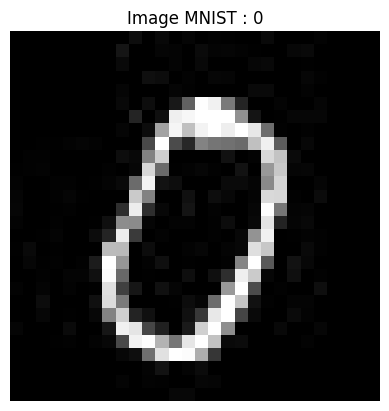

Matrice de pixels :
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,   8.,
           0.,   5.,   0.,   2.,   1.,   0.,   0.,   9.,   0.,   0.,   0.,   3.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  21.,   0.,   0.,   5.,
           4.,   0.,  10.,   4.,   5.,   3.,   1.,   0.,   0.,   7.,   9.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   0.,   0.,   0.,
           4.,   0.,   8.,   0.,   0.,   0.,   6.,   8.,   0.,   0.,   1.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  15.,  12.,
           0.,   3.,   0.,   6.,   5.,   0.,   0.,   0.,   0.,   0.,   6.,   2.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,
           5.,   2.,   0.,   0.,   0.,   0.,   9.,   9.,   0.,   0.,   3.,   0.,
           0.,   0.,   0.,   0.],


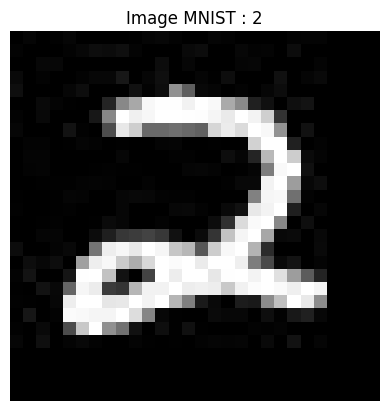

Matrice de pixels :
tensor([[  0.,   5.,   0.,   2.,   6.,   0.,   0.,   0.,   0.,   1.,   5.,   7.,
           3.,   0.,   0.,   5.,   3.,   0.,   0.,   0.,   0.,   3.,   4.,   4.,
           0.,   0.,   0.,   0.],
        [  3.,   0.,   0.,   0.,   3.,   7.,  13.,  11.,  15.,   4.,   0.,   0.,
           0.,   9.,  12.,   0.,   0.,   7.,   3.,   4.,   0.,  12.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   7.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.,
           0.,   6.,   0.,   0.,   0.,   5.,   6.,   0.,   0.,   0.,   0.,   4.,
           0.,   0.,   0.,   0.],
        [  9.,   0.,   3.,   0.,   0.,   3.,   7.,   7.,  23.,   0.,   6.,  15.,
           0.,   0.,   5.,   1.,  13.,   0.,   0.,   0.,  16.,   0.,   5.,   9.,
           0.,   0.,   0.,   0.],
        [ 14.,   0.,   0.,   0.,   6.,  13.,   0.,   0.,   0.,  17.,   3.,  13.,
         145.,  95.,   8.,   5.,   0.,   3.,   0.,   6.,  12.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],


In [7]:
# Iterate through batches of data
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Data: {inputs.shape}")  # Shape of the batch data
    print(f"Target: {labels.shape}")  # Shape of the batch labels
    print(f"First image in the batch: {inputs[0]}")  # The first image in the batch
    show_image(inputs[0].reshape((28,28)), labels[0])
    print(f"First label in the batch: {labels[0]}")  # The label of the first image in the batch
    if batch_idx == 1:  # Let's print details for the first 2 batches
        break

## 1. Un modele MLP simple avec une couche cachee

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 64) # Première couche (taille d'entrée 2, taille de sortie 2)
        self.fc2 = nn.Linear(64, 10) # Deuxième couche (taille d'entrée 2, taille de sortie 2)
        
    def forward(self, x):
        # # Flatten the input image (batch_size, 28, 28) -> (batch_size, 784)
        # x = x.view(-1, 28*28)  # -1 means automatically adjust the batch size
        
        u1 = self.fc1(x)
        u2 = torch.relu(u1)
        u3 = self.fc2(u2)
        #h = torch.softmax(u3, dim=0)
        return u3
        


In [9]:
%%time
# Fonction pour entraîner le modèle
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Mettre les gradients à zéro
            optimizer.zero_grad()

            # Passer les données à travers le modèle
            outputs = model(inputs)

            # Calculer la perte
            loss = loss_fn(outputs, labels)
            
            # Faire la rétropropagation
            loss.backward()

            # Mettre à jour les poids
            optimizer.step()

            # Calculer la précision
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # TODO: Évaluer sur le jeu de validation après chaque époque

import torch.optim as optim
modelMLP = SimpleMLP()
optimizer = optim.Adam(modelMLP.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()  # Perte pour la classification multi-classes

train_model(modelMLP, train_loader, val_loader, optimizer, loss_fn, epochs=10)
# # Save the model's state_dict
# torch.save(modelMLP.state_dict(), "modelMLP.pth")

Epoch [1/10], Loss: 0.8975, Accuracy: 82.85%
Epoch [2/10], Loss: 0.3167, Accuracy: 91.09%
Epoch [3/10], Loss: 0.2370, Accuracy: 93.13%
Epoch [4/10], Loss: 0.2041, Accuracy: 94.16%
Epoch [5/10], Loss: 0.1938, Accuracy: 94.47%
Epoch [6/10], Loss: 0.2002, Accuracy: 94.23%
Epoch [7/10], Loss: 0.1799, Accuracy: 94.76%
Epoch [8/10], Loss: 0.1744, Accuracy: 94.88%
Epoch [9/10], Loss: 0.1638, Accuracy: 95.37%
Epoch [10/10], Loss: 0.1566, Accuracy: 95.52%
CPU times: user 44.4 s, sys: 148 ms, total: 44.6 s
Wall time: 8.24 s


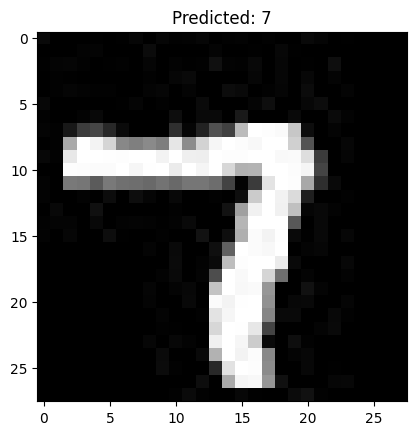

In [10]:
# importlib.reload(utils)
utils.random_predict_and_show(modelMLP, test_loader)

In [12]:
# importlib.reload(utils)

predictions = utils.predict_test(modelMLP, test_loader)
# Save predictions to a text file (one per line)
import pandas as pd
predictions_df = pd.DataFrame({
    'Predicted Label': predictions
})
# Save the predictions DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)
# # get_result("VOTRE_NOM votre prenom", 'predictions.csv')
utils.get_result("NGUYEN Vincent", 'predictions.csv')
utils.show_ranking()

ConnectionError: HTTPConnectionPool(host='webvinc.iuto.ovh', port=80): Max retries exceeded with url: /evaluate (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x724a9cdf7820>: Failed to resolve 'webvinc.iuto.ovh' ([Errno -2] Name or service not known)"))

## 2. Un modele CNN simple avec une couche CNN

In [ ]:
# def load_mnist_data(base_folder_path, split="train"):
#     X, y = utils.load_data(base_folder_path, split)
#     X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
#     y_tensor = torch.tensor(y, dtype=torch.long)
#     return X_tensor, y_tensor

# X_train, y_train = load_mnist_data(base_folder_path, "train")
# X_val, y_val = load_mnist_data(base_folder_path, "val")
# X_test, y_test = load_mnist_data(base_folder_path, "test")

# # Créer des DataLoaders pour l'entraînement et la validation
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
# test_dataset = TensorDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
%%time
# Simple CNN model with 1 Convolutional Layer
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional Layer: 1 input channel (grayscale), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling with 2x2 filter
        self.fc1 = nn.Linear(8 * 14 * 14, 10)  # Fully connected layer for 10 classes

    def forward(self, x):
        # Apply convolution and pooling
        x = self.pool(torch.relu(self.conv1(x)))  # Apply ReLU activation after convolution
        # Flatten the output for the fully connected layer
        x = x.view(-1, 8 * 14 * 14)
        # Fully connected layer
        x = self.fc1(x)
        return x
    
modelCNN = SimpleCNN()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()  # Perte pour la classification multi-classes

train_model(modelCNN, train_loader, val_loader, optimizer, loss_fn, epochs=10)
# Save the model's state_dict
torch.save(modelCNN.state_dict(), "modelSimpleCNN.pth")

In [ ]:
predictions = utils.predict_test(modelCNN, test_loader)
# Save predictions to a text file (one per line)

import pandas as pd
predictions_df = pd.DataFrame({
    'Predicted Label': predictions
})
# Save the predictions DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)
# # get_result("VOTRE_NOM votre prenom", 'predictions.csv')
utils.get_result("NGUYEN Vincent", 'predictions.csv')
utils.show_ranking()